In [1]:
# Three different ways of running mxnet on classic MNIST data

In [2]:
import wget
import os

def download_file(url):
    """
    Downloads a file from a url if the file does not exist in the current folder
    :param url: Url to the file
    """
    local_filename = url.split('/')[-1]
    if os.path.isfile(local_filename):
        print("The file %s already exist in the current directory" % local_filename)
    else:
        print('downloading data: %s' % url)
        response = wget.download(url)
        print('saved data')

In [3]:
import sys

url_train = 'https://hoaphumanoidstorage2.blob.core.windows.net/public/mnist_train.csv'
url_test = 'https://hoaphumanoidstorage2.blob.core.windows.net/public/mnist_test.csv'

print("Downloading file %s" % url_train)
download_file(url_train)

print("Downloading file %s" % url_test)
download_file(url_test)

The file mnist_train.csv already exist in the current directory
The file mnist_test.csv already exist in the current directory


In [4]:
#http://yann.lecun.com/exdb/mnist/
%matplotlib inline
import numpy as np
import pandas as pd
import mxnet as mx
import time
import math
import matplotlib.pyplot as plt
import logging

In [5]:
BATCH_SIZE = 100
DATA_SHAPE = (BATCH_SIZE, 1, 28, 28)
EPOCHS = 10
LR  = 0.1
MOM = 0.9
WD = 0.00001

In [6]:
# logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='lenet.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [7]:
# gather data
train = pd.read_csv('mnist_train.csv', header=None)
train_y = train[[0]].values.ravel()
train_x = train.iloc[:,1:].values

# modify data
train_x = np.array(train_x, dtype='float32').reshape((-1, 1, 28, 28))
#print(train_x.shape)  # (60000, 1, 28, 28)
# normalise (between 0 and 1)
train_x[:] /= 255.0

# iterator to feed mini_batch at a time
# returns <mxnet.io.DataBatch object at 0x000001AA996B38D0> 
# type <class 'mxnet.io.DataBatch'>
train_iter = mx.io.NDArrayIter(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
def create_lenet():
    # create symbolic representation
    data = mx.symbol.Variable('data')
    input_y = mx.sym.Variable('softmax_label')  # placeholder for output

    conv1 = mx.symbol.Convolution(
        data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.symbol.Activation(
        data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(
        data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2 = mx.symbol.Convolution(
        data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.symbol.Activation(
        data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(
        data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2)) 

    flatten = mx.symbol.Flatten(
        data=pool2)
    
    fc1 = mx.symbol.FullyConnected(
        data=flatten, num_hidden=500) 
    tanh3 = mx.symbol.Activation(
        data=fc1, act_type="tanh")

    fc2 = mx.symbol.FullyConnected(
        data=tanh3, num_hidden=10) 

    lenet = mx.symbol.SoftmaxOutput(
        data=fc2, label=input_y, name="softmax")
    return lenet

# train the NN
ctx = mx.cpu()
cnn = create_lenet()

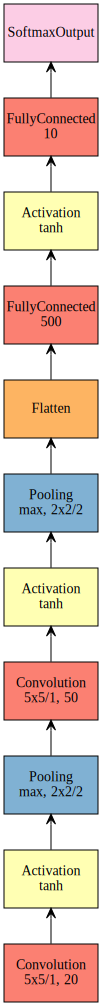

In [9]:
# Visualise symbol (for crepe)
mx.viz.plot_network(cnn)

In [10]:
cnn.list_arguments()

['data',
 'convolution0_weight',
 'convolution0_bias',
 'convolution1_weight',
 'convolution1_bias',
 'fullyconnected0_weight',
 'fullyconnected0_bias',
 'fullyconnected1_weight',
 'fullyconnected1_bias',
 'softmax_label']

### Training Method A - Simple

This approach creates the model by automatically binding the symbol `cnn` and letting us define parameters such as learning rate, etc. 

We then train the model using the `model.fit()` function which accepts an mx.io.iterator for the input and we can optionally save the parameters and log every batch/epoch

In [75]:
# Setup model
model = mx.model.FeedForward(
    ctx = ctx,
    symbol = cnn, 
    num_epoch = EPOCHS,  # number of training rounds
    learning_rate = LR,  # learning rate
    momentum = MOM,   # momentum for sgd
    wd = WD  # weight decay for reg
)

In [ ]:
# Train
# Log accuracy to file every batch
# Save parameters at every epoch
tic = time.time()

model.fit(
    X = train_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("lenet_checkp_") 
)

print("Finished training in %.0f seconds" % (time.time() - tic))
# Finished training in 577 seconds

In [15]:
# prediction of test set
test = pd.read_csv('mnist_test.csv', header=None)
test_y = test[[0]].values.ravel()
test_x = test.iloc[:,1:].values

test_x = np.array(test_x, dtype='float32').reshape((-1, 1, 28, 28))
test_x[:] /= 255.0

test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size=100)

# most likely will be last element after sorting
pred = np.argsort(model.predict(X = test_iter))[:,-1]

# accuracy
print(sum(pred==test_y)/len(test_y))
# 0.9901

# save
np.savetxt('predicted_images.csv', np.c_[pred, test_y], delimiter=',', fmt='%d')

0.9901


### Training Method B - Advanced

Instead of using `mx.model.FeedForward` along with `model.fit` we can get more control creating it manually. 

This stage involves manually attaching the created symbol to the executor, linking the data and label, initialising the weights, and then creating the optimiser (loss).

This is particularly useful because it allows us to use a manual_iterator (which can apply an on-the-fly transformation to the data). In this example we normalise on the fly - however this can also be used to produce one-hot-vectors which would massively expand the size of the data.

In [10]:
# create own iterator (that can optionally apply transform function)
def manual_iterator(infile, batch_size=100, shuffle=True):

    """ Accepts 'infile' location to a .csv and then yields numpy arrays
    wrapped as NDarrays using mx.nd.array(np.array(data, dtype='float32'))
    reshaped for the CNN symbol i.e. .reshape((LENGTH, 1, FEAT, DIM))"""
    
    # load in data
    df = pd.read_csv(infile, header=None)
    
    # shuffle
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    
    train_x, train_y = df.iloc[:,1:].values, df[[0]].values.ravel()

    # modify data
    train_x = np.array(train_x, dtype='float32').reshape((-1, 1, 28, 28))
    
    # transformation
    train_x[:] /= 255.0    
    
    # yield mini-batches as NDArray
    X_split = np.zeros(DATA_SHAPE, dtype='float32')
    for ti, tx in enumerate(train_x):

        X_split[ti%batch_size][0] = tx

        if (ti + 1) % batch_size == 0:
            yield mx.nd.array(X_split), mx.nd.array(train_y[ti+1-batch_size:ti+1])   
            X_split = np.zeros(DATA_SHAPE, dtype='float32')
            
def example(infile='mnist_train.csv'):
    
    mbatch = 3
    df = pd.read_csv(infile, header=None)
    train_y = df[[0]].values.ravel()
    print("actual: ", train_y[:mbatch*4])
        
    counter = 0
    for batchX, batchY in manual_iterator(infile, batch_size=mbatch, shuffle=False):
        print("batch: ", batchY.asnumpy().astype('int32'))
        counter += 1
        if counter == 4:
            break   

In [11]:
example()

actual:  [5 0 4 1 9 2 1 3 1 4 3 5]
batch:  [5 0 4]
batch:  [1 9 2]
batch:  [1 3 1]
batch:  [4 3 5]


In [25]:
ctx = mx.cpu()
cnn = create_lenet()

# Manually set-up the training process
input_shapes = {'softmax_label': (BATCH_SIZE,),
                'data': DATA_SHAPE}

# Attach symbol to executor
exe = cnn.simple_bind(ctx=mx.cpu(), **input_shapes)
   
# Create link to data and label (to symbol)
arg_arrays = dict(zip(cnn.list_arguments(), exe.arg_arrays))
data = exe.arg_dict['data']
label = exe.arg_dict['softmax_label']

# init weights
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)    

# Stochastic gradient descent
opt = mx.optimizer.SGD(
    learning_rate=LR,
    momentum=MOM,
    wd=WD,
    rescale_grad=1.0/BATCH_SIZE)
updater = mx.optimizer.get_updater(opt)

In [26]:
tic = time.time()

# Evaluation metric:
metric = mx.metric.Accuracy()

# Train EPOCHS
for epoch in range(EPOCHS):
    t = 0   
    for batchX, batchY in manual_iterator('mnist_train.csv', batch_size=BATCH_SIZE, shuffle=True):
        # Copy data to executor input
        data[:] = batchX
        label[:] = batchY
        # forward
        exe.forward(is_train=True)
        # backward
        exe.backward()
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        # get metric
        metric.update([batchY], exe.outputs)
        # log every batch
        t += 1
        if t % BATCH_SIZE == 0:
            toc = time.time()
            train_t = toc - tic
            metric_m, metric_v = metric.get()
            print("epoch: %d iter: %d metric(%s): %.4f dur: %.0f" % (epoch, t, metric_m, metric_v, train_t))

print("Finished training in %.0f seconds" % (time.time() - tic))
            
"""
{'softmax_label': (100,), 'data': (100, 1, 28, 28)}
epoch: 0 iter: 100 metric(accuracy): 0.1112 dur: 16.0193
epoch: 0 iter: 200 metric(accuracy): 0.4231 dur: 25.5562
epoch: 0 iter: 300 metric(accuracy): 0.5941 dur: 35.2233
epoch: 0 iter: 400 metric(accuracy): 0.6852 dur: 45.1762
epoch: 0 iter: 500 metric(accuracy): 0.7413 dur: 56.0308
epoch: 0 iter: 600 metric(accuracy): 0.7797 dur: 66.4584
epoch: 1 iter: 100 metric(accuracy): 0.8076 dur: 15.9844#
...
epoch: 9 iter: 600 metric(accuracy): 0.9713 dur: 64.6901
Finished training in 646 seconds
"""

epoch: 0 iter: 100 metric(accuracy): 0.1112 dur: 16.0193
epoch: 0 iter: 200 metric(accuracy): 0.4231 dur: 25.5562
epoch: 0 iter: 300 metric(accuracy): 0.5941 dur: 35.2233
epoch: 0 iter: 400 metric(accuracy): 0.6852 dur: 45.1762
epoch: 0 iter: 500 metric(accuracy): 0.7413 dur: 56.0308
epoch: 0 iter: 600 metric(accuracy): 0.7797 dur: 66.4584
epoch: 1 iter: 100 metric(accuracy): 0.8076 dur: 15.9844
epoch: 1 iter: 200 metric(accuracy): 0.8290 dur: 25.6956
epoch: 1 iter: 300 metric(accuracy): 0.8453 dur: 35.3136
epoch: 1 iter: 400 metric(accuracy): 0.8586 dur: 45.0332
epoch: 1 iter: 500 metric(accuracy): 0.8696 dur: 54.7026
epoch: 1 iter: 600 metric(accuracy): 0.8789 dur: 64.4354
epoch: 2 iter: 100 metric(accuracy): 0.8871 dur: 15.7670
epoch: 2 iter: 200 metric(accuracy): 0.8942 dur: 25.3493
epoch: 2 iter: 300 metric(accuracy): 0.9003 dur: 34.8345
epoch: 2 iter: 400 metric(accuracy): 0.9055 dur: 44.3858
epoch: 2 iter: 500 metric(accuracy): 0.9102 dur: 54.0566
epoch: 2 iter: 600 metric(accur

"\n{'softmax_label': (100,), 'data': (100, 1, 28, 28)}\nepoch: 0 iter: 100 metric(accuracy): 0.1122 dur: 15.8803\nepoch: 0 iter: 200 metric(accuracy): 0.4161 dur: 25.6026\nepoch: 0 iter: 300 metric(accuracy): 0.5904 dur: 35.3213\nepoch: 0 iter: 400 metric(accuracy): 0.6830 dur: 44.9783\nepoch: 0 iter: 500 metric(accuracy): 0.7395 dur: 54.6165\n"

In [28]:
# Test
metric = mx.metric.Accuracy()

for batchX, batchY in manual_iterator('mnist_test.csv', batch_size=BATCH_SIZE):
    data[:] = batchX
    label[:] = batchY
    # forward
    exe.forward(is_train=False)
    # metric for prediction
    metric.update([batchY], exe.outputs)

metric_m, metric_v = metric.get()
print("metric(%s): %.4f" % (metric_m, metric_v))

# metric(accuracy): 0.9902

metric(accuracy): 0.9902


### Training Method C - Advanced

With this approach we create our own iterator which inherits the `DataIter` class, this means
we can use it in the normal training approach

In [11]:
from collections import OrderedDict
from mxnet.ndarray import array, NDArray
from mxnet.io import DataBatch

def init_data(data, default_name):
    data = OrderedDict([(default_name, [data][0])])
    for k, v in data.items():
        if not isinstance(v, NDArray):
            data[k] = array(v)
    return list(data.items())

def csv_to_np(infile):
    df = pd.read_csv(infile, header=None)
    data, label = df.iloc[:,1:].values, df[[0]].values.ravel()
    data = np.array(data, dtype='float32').reshape((-1, 1, 28, 28))
    data[:] /= 255.0  # normalise        
    return data, label

class CustomIter(mx.io.DataIter):
    
    """ 
    Given response on github: You can inherit mx.io.DataIter
    to create your own data iterator.
    You only need to implement provide_data, provide_label, next() 
    
    This inherits from mx.io.DataIter"""
    
    def __init__(self, infile, batch_size=100, shuffle=False):
        
        super(CustomIter, self).__init__()

        # Load all CSV into array
        data, label = csv_to_np(infile)
            
        self.data = init_data(data, 'data')
        self.label = init_data(label, 'softmax_label')
        
        # shuffle
        if shuffle:
            idx = np.arange(self.data[0][1].shape[0])
            np.random.shuffle(idx)  # in-place
            self.data = [(k, array(v.asnumpy()[idx], v.context)) for k, v in self.data]
            self.label = [(k, array(v.asnumpy()[idx], v.context)) for k, v in self.label]
            
        # batching
        self.data_list = [x[1] for x in self.data] + [x[1] for x in self.label]
        self.num_source = len(self.data_list)
        self.num_data = self.data_list[0].shape[0]
        assert self.num_data >= batch_size, \
            "batch_size need to be smaller than data size."
        self.cursor = -batch_size
        self.batch_size = batch_size
        
    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        return [(k, tuple([self.batch_size] + list(v.shape[1:]))) for k, v in self.data]

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        return [(k, tuple([self.batch_size] + list(v.shape[1:]))) for k, v in self.label]
    
    def reset(self):
        self.cursor = -self.batch_size
        
    def iter_next(self):
        self.cursor += self.batch_size
        if self.cursor < self.num_data:
            return True
        else:
            return False
     
    def next(self):
        if self.iter_next():
            return DataBatch(
                data=self._getdata(self.data), 
                label=self._getdata(self.label),
                pad=self.getpad(),
                index=None)
        else:
            raise StopIteration
        
    def _getdata(self, data_source):
        """Load data from underlying arrays, internal use only. Any
        transformation functions would go here ...
        
        For example creating one-hot encodings, etc."""
        
        assert(self.cursor < self.num_data), "DataIter needs reset."
        
        if self.cursor + self.batch_size <= self.num_data:
            return [x[1][self.cursor:self.cursor+self.batch_size] for x in data_source]
        
        else:
            pad = self.batch_size - self.num_data + self.cursor
            return [concatenate([x[1][self.cursor:], x[1][:pad]]) for x in data_source]
    
    def getpad(self):
        if self.cursor + self.batch_size > self.num_data:
            return self.cursor + self.batch_size - self.num_data
        else:
            return 0

In [12]:
# Setup model
model = mx.model.FeedForward(
    ctx = ctx,
    symbol = cnn, 
    num_epoch = EPOCHS,  
    learning_rate = LR,  
    momentum = MOM,   
    wd = WD  
)

In [13]:
# Link our custom iterator
cust_iter = CustomIter('mnist_train.csv', batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# Train
tic = time.time()

model.fit(
    X = cust_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("lenet_checkp_") 
)

print("Finished training in %.0f seconds" % (time.time() - tic))
# Finished training in 577 seconds

Finished training in 585 seconds


In [15]:
# Predict
test_iter = CustomIter('mnist_test.csv', batch_size=BATCH_SIZE)

# most likely will be last element after sorting
pred = np.argsort(model.predict(X = test_iter))[:,-1]

# accuracy
test = pd.read_csv('mnist_test.csv', header=None)
test_y = test[[0]].values.ravel()

print(sum(pred==test_y)/len(test_y))
# 0.991

0.991
